In [1]:
from pm4py.objects.conversion.log import converter as xes_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
import pandas as pd
import seaborn as sns

In [2]:
log = xes_importer.apply('BPI Challenge 2017 - Offer log.xes')
df = xes_converter.apply(log, variant=xes_converter.Variants.TO_DATA_FRAME)


parsing log, completed traces ::   0%|          | 0/42995 [00:00<?, ?it/s]

In [3]:
df = df.sort_values(by = 'time:timestamp')
df.head(5)


,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
0,Created,User_17,O_Create Offer,Offer,Offer_247135719,complete,2016-01-02 09:17:05.720000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,NaN
1,statechange,User_17,O_Created,Offer,OfferState_124849367,complete,2016-01-02 09:17:08.762000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
2,statechange,User_17,O_Sent (online only),Offer,OfferState_440662877,complete,2016-01-02 09:19:21.330000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
3,statechange,User_17,O_Cancelled,Offer,OfferState_591416028,complete,2016-01-02 09:21:26.034000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
4,Created,User_17,O_Create Offer,Offer,Offer_941964966,complete,2016-01-02 09:21:42.022000+00:00,Offer_941964966,201.76,False,Application_196483749,4100.0,0,10000.0,57,True,NaN


In [4]:
#135694
# Parsing transaction from dataframe 
# All the transaction are  in the 'transaction' list
def parse_data(df) :
    table = {}
    transaction = []
    for index,row in df.iterrows():
        if row['case:Accepted'] == False :
            continue
        if row['Action'] == 'Created' :
            if row['org:resource'] in table :
                transaction.append(table[row['org:resource']])
                del table[row['org:resource']]
            table[row['org:resource']] = [];
            table[row['org:resource']].append(row['concept:name'])
        else :
            if row['org:resource'] in table :
                table[row['org:resource']].append(row['concept:name'])
                if row['concept:name'] == 'O_Cancelled' or row['concept:name'] == 'O_Accepted' or row['concept:name'] == 'O_Refused' : 
                    transaction.append(table[row['org:resource']])
                    del table[row['org:resource']]


    for key, value in table.items() :
        transaction.append(value)


    for i in range(len(transaction)) :
        j = 0
        temp = []
        while(j < len(transaction[i])) :
            if(j == 0 or transaction[i][j] != transaction[i][j - 1]) :
                temp.append(transaction[i][j])
            j += 1
        transaction[i] = temp
    return transaction

def feed_into_the_model(model, seq, last_event) :
    h = str(seq)
    if not h in model:
        if len(seq) != 0 :
            model[h] = {}
            model[h][last_event] = 1
    else :
        if last_event in model[h] :
            model[h][last_event] = model[h][last_event] + 1
        else :
            model[h][last_event] = 1    

O(n * 5 * 5)
def create_model(transaction) :
    model = {}
    for i in range(0, len(transaction)) :
        for j in range(0, len(transaction[i])) :
            seq = []
            for k in range(j, len(transaction[i])) :
                feed_into_the_model(model, seq, transaction[i][k])
                seq.append(transaction[i][k])
            feed_into_the_model(model, seq, 'End')
    return model

transaction = parse_data(df)
model = create_model(transaction)



            


In [8]:
# 

def evaluate_matrix(seq) :
    possible = {}
    last_state = '[' + '\'' + str(seq[len(seq) - 1]) + '\'' + ']'
    mp = model[last_state]
    for key in mp :
        if not key in possible :
            possible[key] = True
    i = len(seq) - 1
    matrix = []
    while(i >= 0) :
        ngram_seq = seq[i : len(seq)]
        ngram_seq = str(ngram_seq)
        matrix.append([])
        idx = len(matrix) - 1
        denom = 0
        if ngram_seq in model :
            for key in possible :
                if key in model[ngram_seq] :
                    denom += model[ngram_seq][key]
            for key in possible :
                if key in model[ngram_seq] :
                    matrix[idx].append([key, model[ngram_seq][key] / denom])
                else :
                    matrix[idx].append([key, 0.0])
        else :
            for key in possible :
                matrix[idx].append([key, 0.0])
        i -= 1
    print('probability matrix')
    for i in range(len(matrix)) :
        print(str(i + 1) + ' gram :', end = '')
        print(matrix[i])
        print()
    #return matrix

def get_prediction(seq) :
    possible = {}
    last_state = '[' + '\'' + str(seq[len(seq) - 1]) + '\'' + ']'
    mp = model[last_state]
    for key in mp :
        if not key in possible :
            possible[key] = True
    i = len(seq) - 1
    next_probable = []
    while(i >= 0) :
        ngram_seq = seq[i : len(seq)]
        ngram_seq = str(ngram_seq)
        denom = 0
        prediction = "None"
        max_prob = 0
        if ngram_seq in model :
            for key in possible :
                if key in model[ngram_seq] :
                    p = model[ngram_seq][key]
                    if p > max_prob :
                        max_prob = p
                        prediction = key
        next_probable.append(prediction)
        i -= 1
    print('predictions')
    for i in range(0, len(next_probable)) :
        print(str(i + 1) + ' gram : ' + next_probable[i])
                
        
seq = ['O_Create Offer', 'O_Created','O_Sent (mail and online)', 'O_Returned']
#seq = ['O_Create Offer', 'O_Created']
#print(model[str(seq)])
#print(seq)
evaluate_matrix(seq)
get_prediction(seq)

probability matrix
1 gram :[['O_Accepted', 0.6219512195121951], ['End', 0.18292682926829268], ['O_Refused', 0.13414634146341464], ['O_Cancelled', 0.06097560975609756]]

2 gram :[['O_Accepted', 0.5833333333333334], ['End', 0.3055555555555556], ['O_Refused', 0.027777777777777776], ['O_Cancelled', 0.08333333333333333]]

3 gram :[['O_Accepted', 0.5833333333333334], ['End', 0.3055555555555556], ['O_Refused', 0.027777777777777776], ['O_Cancelled', 0.08333333333333333]]

4 gram :[['O_Accepted', 0.5833333333333334], ['End', 0.3055555555555556], ['O_Refused', 0.027777777777777776], ['O_Cancelled', 0.08333333333333333]]

predictions
1 gram : O_Accepted
2 gram : O_Accepted
3 gram : O_Accepted
4 gram : O_Accepted


In [21]:
x = evaluate_matrix(seq)

1 gram :[['End', 0.8543115942028986], ['O_Sent (mail and online)', 0.08076086956521739], ['O_Cancelled', 0.059130434782608696], ['O_Returned', 0.0013043478260869566], ['O_Accepted', 0.0012318840579710144], ['O_Refused', 0.002572463768115942], ['O_Sent (online only)', 0.0006884057971014493]]

2 gram :[['End', 0.0], ['O_Sent (mail and online)', 0.5545356371490281], ['O_Cancelled', 0.4030777537796976], ['O_Returned', 0.0091792656587473], ['O_Accepted', 0.0091792656587473], ['O_Refused', 0.018898488120950324], ['O_Sent (online only)', 0.0051295896328293735]]

3 gram :[['End', 0.0], ['O_Sent (mail and online)', 0.5545356371490281], ['O_Cancelled', 0.4030777537796976], ['O_Returned', 0.0091792656587473], ['O_Accepted', 0.0091792656587473], ['O_Refused', 0.018898488120950324], ['O_Sent (online only)', 0.0051295896328293735]]



In [7]:
# create empty dataframe
temp = pd.DataFrame()

#assign matrix values to dataframe
for i in range(len(x)):
    print(x[i])
    temp= temp.append(pd.DataFrame(x[i]))

[['O_Accepted', 0.6219512195121951], ['End', 0.18292682926829268], ['O_Refused', 0.13414634146341464], ['O_Cancelled', 0.06097560975609756]]
[['O_Accepted', 0.5833333333333334], ['End', 0.3055555555555556], ['O_Refused', 0.027777777777777776], ['O_Cancelled', 0.08333333333333333]]
[['O_Accepted', 0.5833333333333334], ['End', 0.3055555555555556], ['O_Refused', 0.027777777777777776], ['O_Cancelled', 0.08333333333333333]]
[['O_Accepted', 0.5833333333333334], ['End', 0.3055555555555556], ['O_Refused', 0.027777777777777776], ['O_Cancelled', 0.08333333333333333]]


In [8]:
#rename columns 
temp.columns = ['Event', 'Prob_Val']

# Plot 1-N Gram

[Text(0.5, 1.0, "sequence = ['O_Create Offer', 'O_Created','O_Sent (mail and online)','O_Returned']")]

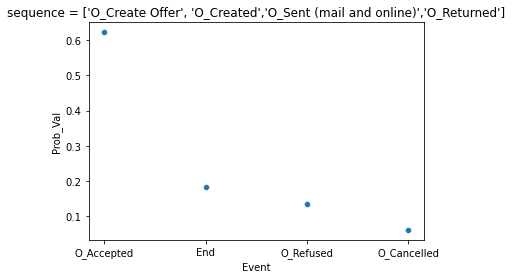

In [9]:
sns.scatterplot(x = 'Event', y ='Prob_Val', data = temp[0:4]).set(title="sequence = ['O_Create Offer', 'O_Created','O_Sent (mail and online)','O_Returned']")

# Plot 2-N Gram

[Text(0.5, 1.0, "sequence = ['O_Create Offer', 'O_Created','O_Sent (mail and online)','O_Returned']")]

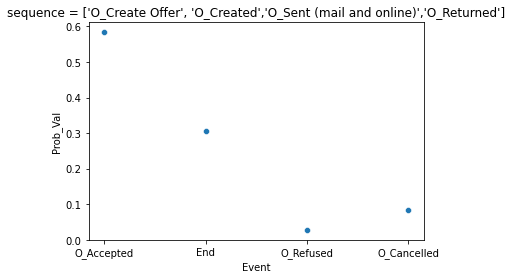

In [10]:
sns.scatterplot(x = 'Event', y ='Prob_Val', data = temp[4:8]).set(title="sequence = ['O_Create Offer', 'O_Created','O_Sent (mail and online)','O_Returned']")

# Plot 3-N Gram

[Text(0.5, 1.0, "sequence = ['O_Create Offer', 'O_Created','O_Sent (mail and online)','O_Returned']")]

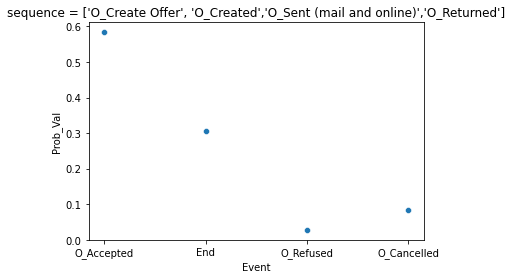

In [11]:
sns.scatterplot(x = 'Event', y ='Prob_Val', data = temp[8:12]).set(title="sequence = ['O_Create Offer', 'O_Created','O_Sent (mail and online)','O_Returned']")

# Plot 4-N Gram

[Text(0.5, 1.0, "sequence = ['O_Create Offer', 'O_Created','O_Sent (mail and online)','O_Returned']")]

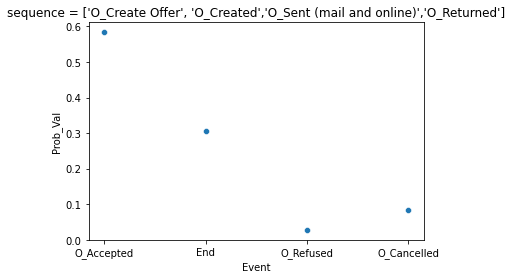

In [12]:
sns.scatterplot(x = 'Event', y ='Prob_Val', data = temp[12:16]).set(title="sequence = ['O_Create Offer', 'O_Created','O_Sent (mail and online)','O_Returned']")